# Fully Convolutional Networks for Semantic Segmentation

In [60]:
import torch
import torchvision.transforms as T
import os
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torchmetrics.segmentation import MeanIoU
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import time
from datetime import datetime
import torch.multiprocessing as mp
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
from datetime import datetime

In [61]:
CLASS_NAMES = [
    "Unlabeled", "Building", "Fence", "Other", "Pedestrian", "Pole",
    "Roadline", "Road", "Sidewalk", "Vegetation", "Car", "Wall", "Traffic sign"
]

Mask image shape: (224, 224, 3)


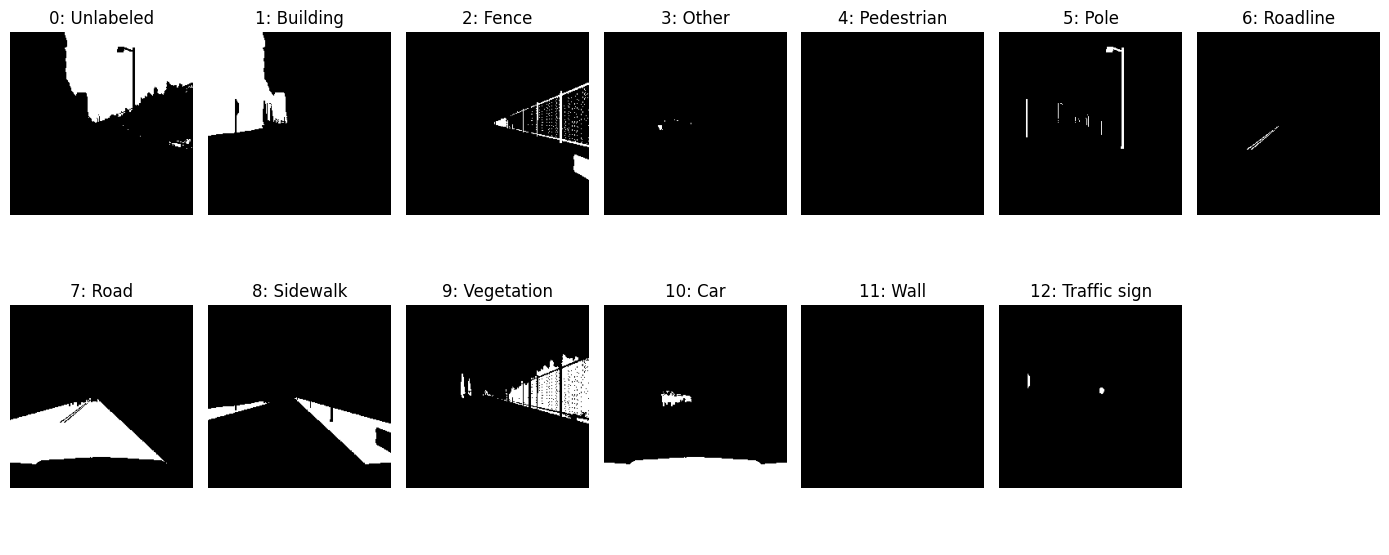

In [62]:
def visualize_masks(mask_path):
    """
    Reads a segmentation mask from the specified path and generates binary masks for each class.
    Each mask highlights pixels belonging to a specific class, with white for the class considered and black for all others.

    Class IDs are in the first channel
    """
    mask_img = Image.open(mask_path)
    mask = np.array(mask_img)
    print(f"Mask image shape: {mask.shape}")
    mask = mask[:, :, 0]  # taking only first channel.

    fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(14, 6))
    axes = axes.flatten()
    
    for class_id in range(13):
        # Create a binary mask: highlight only current class
        binary_mask = (mask == class_id)
        axes[class_id].imshow(binary_mask, cmap='gray')
        axes[class_id].set_title(f"{class_id}: {CLASS_NAMES[class_id]}")
        axes[class_id].axis('off')
    
    for ax in axes[13:]:
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

mask_path = r"C:\Users\raaga\OneDrive\Desktop\IIIT-H\3-2\Computer Vision\assignment-4-rraagav\data\dataset_224\train\labels\02_00_110.png"
visualize_masks(mask_path)

# mask_img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
# if mask_img is None:
#     raise FileNotFoundError(f"Mask image not found at {mask_path}.")

# # print no of channels 
# print(f"Mask image shape: {mask_img.shape}")
# print(np.unique(mask_img[:, :, 0]))
# print(np.unique(mask_img[:, :, 1]))
# print(np.unique(mask_img[:, :, 2]))

### Stick to VGG-16 over VGG-19, equivalent results as seen in the paper. 

```plaintext
VGG16 - 5 Blocks (13 conv layers)

Block 1: Conv(64) → ReLU → Conv(64) → ReLU → MaxPool  
Block 2: Conv(128) → ReLU → Conv(128) → ReLU → MaxPool  
Block 3: Conv(256) → ReLU ×3 → MaxPool  
Block 4: Conv(512) → ReLU ×3 → MaxPool  
Block 5: Conv(512) → ReLU ×3 → MaxPool  
```

```plaintext
VGG16 (Input: 224x224x3)

Block 1: Conv → Conv → MaxPool      → 112x112  
Block 2: Conv → Conv → MaxPool      → 56x56  
Block 3: Conv → Conv → Conv → MaxPool → 28x28  
Block 4: Conv → Conv → Conv → MaxPool → 14x14  
Block 5: Conv → Conv → Conv → MaxPool → 7x7  
```

In [63]:
# LLM Usage, I wanted to make it as efficient as the paper - they used a bilinear kernel, and performed upsampling. 
# I did the upsampling with ConvTranspose2d, I needed to initialize the weights that's all. 

def bilinear_kernel(size):
    factor = (size + 1) // 2
    center = factor - 1 if size % 2 == 1 else factor - 0.5
    og = torch.arange(size).float()
    filt = (1 - torch.abs(og - center) / factor)
    return filt[:, None] * filt[None, :]

def init_bilinear_weights(layer):
    if isinstance(layer, nn.ConvTranspose2d):
        size = layer.kernel_size[0]
        bilinear = bilinear_kernel(size)
        weight = torch.zeros_like(layer.weight)
        for i in range(layer.out_channels):
            weight[i, i] = bilinear
        layer.weight.data.copy_(weight)

In [64]:
def conv1x1(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1)

In [65]:
class FCN_Base(nn.Module):
    def __init__(self, num_classes, freeze_backbone):
        super(FCN_Base, self).__init__()
        self.vgg = models.vgg16(weights='DEFAULT')
        self.num_classes = num_classes
        self.features = self.vgg.features
        # print(len(self.features))
        
        if freeze_backbone:
            for param in self.features.parameters():
                param.requires_grad = False

        self.hidden_channels = 4096
        
        #change from linear to conv
        self.fc6 = nn.Conv2d(512, self.hidden_channels, kernel_size=7, padding=3)
        self.fc7 = nn.Conv2d(self.hidden_channels, self.hidden_channels, kernel_size=1)

        self.score_fr = nn.Conv2d(self.hidden_channels, self.num_classes, kernel_size=1)
        # score is good enough for 32, need to use the conv1x1 for FCN16 and FCN8

    def extract_pools(self, x):
        pools = []
        for layer in self.features:
            x = layer(x)
            if isinstance(layer, nn.MaxPool2d):
                pools.append(x)
        return pools


In [66]:
class FCN32(FCN_Base):
    def __init__(self, num_classes, freeze_backbone):
        super(FCN32, self).__init__(num_classes, freeze_backbone)
        # Old Approach, where I use ConvTranspose, with bilinear weights initialized, it's quicker to use F.interpolate
        # self.upscore32 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16)
        # init_bilinear_weights(self.upscore32)

    def forward(self, x):
        pools = self.extract_pools(x)
        # print(pools)
        _, _, pool5 = pools[2], pools[3], pools[4]

        fc6 = self.fc6(pool5)
        fc7 = self.fc7(fc6)
        fc8 = self.score_fr(fc7)
        
        # Perform Upsampling for the output and for the FCN16 prediction part.     
        # upsampled = self.upscore32(fc8)
        upsampled = F.interpolate(fc8, scale_factor=32, mode='bilinear', align_corners=False)

        # print("pool5:", pool5.shape)
        # print("fc6:", fc6.shape)
        # print("fc7:", fc7.shape)
        # print("fc8:", fc8.shape)
        # print("upsampled:", upsampled.shape)
        return upsampled

In [67]:
class FCN16(FCN_Base):
    def __init__(self, num_classes, freeze_backbone):
        super(FCN16, self).__init__(num_classes, freeze_backbone)
        self.score_pool4 = conv1x1(512, num_classes)
        # Old Approach, where I use ConvTranspose, with bilinear weights initialized, it's quicker to use F.interpolate
        # self.upscore16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8)
        # init_bilinear_weights(self.upscore16)

    def forward(self, x):
        pools = self.extract_pools(x)
        # print(pools)
        _, pool4, pool5 = pools[2], pools[3], pools[4]

        fc6 = self.fc6(pool5)
        fc7 = self.fc7(fc6)
        fc8 = self.score_fr(fc7) # get the final residuals after pool5

        fc8_upsampled = F.interpolate(fc8, size=pool4.shape[2:], mode='bilinear', align_corners=False)
        pool4_score = self.score_pool4(pool4)
        fused = fc8_upsampled + pool4_score

        upsampled = F.interpolate(fused, scale_factor=16, mode='bilinear', align_corners=False)
        
        # print("pool4:", pool4.shape)
        # print("pool5:", pool5.shape)
        # print("fc8:", fc8.shape)
        # print("score4:", pool4_score.shape)
        # print("fused:", fused.shape)
        # print("upsampled:", upsampled.shape)

        return upsampled

In [68]:
class FCN8(FCN_Base):
    def __init__(self, num_classes, freeze_backbone):
        super().__init__(num_classes, freeze_backbone)
        self.score_pool4 = conv1x1(512, num_classes)
        self.score_pool3 = conv1x1(256, num_classes)
        # Old Approach, where I use ConvTranspose, with bilinear weights initialized, it's quicker to use F.interpolate
        # self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4)
        # init_bilinear_weights(self.upscore8)

    def forward(self, x):
        pools = self.extract_pools(x)
        pool3, pool4, pool5 = pools[2], pools[3], pools[4]

        fc6 = self.fc6(pool5)
        fc7 = self.fc7(fc6)
        fc8 = self.score_fr(fc7) # get the final residuals after pool5

        # Get the first fusion, from pool4 and pool5
        fc8_up = F.interpolate(fc8, size=pool4.shape[2:], mode='bilinear', align_corners=False)
        pool4_score = self.score_pool4(pool4)
        fused1 = fc8_up + pool4_score  # Intermediate fused feature

        # Upsample first fusion to match pool3
        fused1_up = F.interpolate(fused1, size=pool3.shape[2:], mode='bilinear', align_corners=False)
        pool3_score = self.score_pool3(pool3)
        forest_fusion = fused1_up + pool3_score 

        upsampled = F.interpolate(forest_fusion, scale_factor=8, mode='bilinear', align_corners=False)

        # print("pool3:", pool3.shape)
        # print("pool4:", pool4.shape)
        # print("pool5:", pool5.shape)
        # print("fc8:", fc8.shape)
        # print("score3:", pool3_score.shape)
        # print("fused1:", fused1.shape)
        # print("forest_fusion:", forest_fusion.shape)
        # print("upsampled:", upsampled.shape)

        return upsampled

In [69]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

mask_transform = T.Compose([
    T.Resize((224, 224), interpolation=Image.NEAREST),
    T.PILToTensor()
])

In [70]:
num_classes = 13

In [71]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        mask_name = self.mask_filenames[idx]
        
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        image = Image.open(image_path).convert('RGB')
        # For this dataset, masks have class IDs in the first channel
        mask = Image.open(mask_path)
        mask_array = np.array(mask)[:,:,0]  # Extract first channel which contains class IDs
        mask = Image.fromarray(mask_array)
        
        if self.transform is not None:
            image = self.transform(image)
        
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
            # Convert to long and squeeze out the channel dimension
            mask = mask.squeeze(0).long()  # This fixes the Byte vs Long issue
        else:
            mask = torch.from_numpy(np.array(mask, dtype=np.int64))
            
        return image, mask

In [72]:
# Data Directories 
train_image_dir = r"C:\Users\raaga\OneDrive\Desktop\IIIT-H\3-2\Computer Vision\assignment-4-rraagav\data\dataset_224\train\images"
train_mask_dir = r"C:\Users\raaga\OneDrive\Desktop\IIIT-H\3-2\Computer Vision\assignment-4-rraagav\data\dataset_224\train\labels"
test_image_dir = r"C:\Users\raaga\OneDrive\Desktop\IIIT-H\3-2\Computer Vision\assignment-4-rraagav\data\dataset_224\test\images"
test_mask_dir = r"C:\Users\raaga\OneDrive\Desktop\IIIT-H\3-2\Computer Vision\assignment-4-rraagav\data\dataset_224\test\labels"

In [73]:
from torch.utils.data import random_split

batch_size = 32
num_workers = 0
pin_memory = False  

train_dataset_full = SegmentationDataset(train_image_dir, train_mask_dir, transform=transform, mask_transform=mask_transform)

val_percent = 0.2
val_size = int(val_percent * len(train_dataset_full))
train_size = len(train_dataset_full) - val_size

train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

test_dataset = SegmentationDataset(test_image_dir, test_mask_dir, transform=transform, mask_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

print(f"Dataset sizes: Train {len(train_dataset)}, Val {len(val_dataset)}, Test {len(test_dataset)}")
print(f"Using {num_workers} dataloader workers")

Dataset sizes: Train 1600, Val 400, Test 500
Using 0 dataloader workers


In [74]:
def train_epoch(model, dataloader, optimizer, criterion, scaler, epoch, device):
    """
    Train for one epoch with mixed precision
    
    Returns:
        epoch_loss: Average loss for this epoch
        epoch_iou: Mean IoU for this epoch
        batch_times: List of batch processing times for performance analysis
    """
    model.train()
    running_loss = 0.0
    train_iou = MeanIoU(num_classes=num_classes).to(device)
    batch_times = []
    
    # Use tqdm for progress tracking in notebook
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    
    for i, (images, labels) in enumerate(progress_bar):
        start_time = time.time()
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero gradients for each batch
        optimizer.zero_grad(set_to_none=True)  # Slightly more efficient than zero_grad()

        # Use AMP for mixed precision training
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Scale gradients and backpropagate
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update metrics
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        train_iou.update(preds, labels)
        
        # Update progress bar with current loss
        batch_time = time.time() - start_time
        batch_times.append(batch_time)
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'batch_time': f"{batch_time:.3f}s"
        })

    # Compute epoch metrics    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_iou = train_iou.compute().item()
    
    return epoch_loss, epoch_iou, batch_times

In [75]:
def validate_epoch(model, dataloader, criterion, epoch, device):
    """
    Validate model on the validation dataset
    
    Returns:
        epoch_loss: Average loss on validation set
        epoch_iou: Mean IoU on validation set
        class_ious: Per-class IoU values
        predictions: Sample of predictions for visualization
    """
    model.eval()
    running_loss = 0.0
    val_iou = MeanIoU(num_classes=num_classes).to(device)
    
    # Store a few predictions for visualization
    predictions = []
    ground_truths = []
    input_images = []
    max_samples = 4  # Number of samples to store
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation", leave=False)
    
    with torch.no_grad():  # No gradients needed for validation
        for i, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            preds = outputs.argmax(dim=1)
            val_iou.update(preds, labels)
            
            # Store samples for visualization (only from the first batch)
            if i == 0 and len(predictions) < max_samples:
                # Store a few examples for visualization
                for j in range(min(max_samples, images.size(0))):
                    input_images.append(images[j].cpu())
                    predictions.append(preds[j].cpu())
                    ground_truths.append(labels[j].cpu())
            
            progress_bar.set_postfix({'val_loss': f"{loss.item():.4f}"})
    
    # Compute epoch metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_iou = val_iou.compute().item()
    
    # Calculate per-class IoU manually
    class_ious = torch.zeros(num_classes, device=device)
    
    # Method 1: If your version of torchmetrics has a method to get per-class IoUs
    try:
        class_ious = val_iou.compute_per_class_iou().cpu().numpy()
    except:
        # Method 2: Calculate per-class IoUs manually
        for i in range(num_classes):
            # Select samples for this class
            tp = 0
            fp = 0
            fn = 0
            
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(dataloader):
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    outputs = model(images)
                    preds = outputs.argmax(dim=1)
                    
                    # Calculate TP, FP, FN for this class
                    pred_mask = (preds == i)
                    target_mask = (labels == i)
                    
                    tp += torch.logical_and(pred_mask, target_mask).sum().item()
                    fp += torch.logical_and(pred_mask, ~target_mask).sum().item()
                    fn += torch.logical_and(~pred_mask, target_mask).sum().item()
            
            # Calculate IoU for this class
            if tp + fp + fn > 0:
                class_ious[i] = tp / (tp + fp + fn)
    
    return epoch_loss, epoch_iou, class_ious.cpu().numpy(), (input_images, predictions, ground_truths)

In [76]:
def visualize_predictions(viz_data, class_names, epoch, save_dir, model_name):
    """
    Visualize predictions from the validation set
    
    Args:
        viz_data: Tuple of (input_images, predictions, ground_truths)
        class_names: List of class names
        epoch: Current epoch
        save_dir: Directory to save visualizations
        model_name: Name of the model for file naming
    """
    input_images, predictions, ground_truths = viz_data
    
    # Create a color map for segmentation visualization
    # Define a colormap - one color per class
    np.random.seed(42)  # For reproducibility
    colors = np.random.randint(0, 255, size=(len(class_names), 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]  # Background/unlabeled as black
    
    plt.figure(figsize=(15, 5 * len(predictions)))
    
    for i, (img, pred, gt) in enumerate(zip(input_images, predictions, ground_truths)):
        # Convert image from tensor to numpy
        img = img.cpu().numpy().transpose(1, 2, 0)
        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Convert predictions and ground truth to color images
        pred_color = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
        gt_color = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
        
        for class_idx in range(len(class_names)):
            pred_mask = (pred == class_idx).cpu().numpy()
            gt_mask = (gt == class_idx).cpu().numpy()
            
            pred_color[pred_mask] = colors[class_idx]
            gt_color[gt_mask] = colors[class_idx]
        
        # Plot side by side
        plt.subplot(len(predictions), 3, i*3 + 1)
        plt.imshow(img)
        plt.title(f"Input Image")
        plt.axis('off')
        
        plt.subplot(len(predictions), 3, i*3 + 2)
        plt.imshow(gt_color)
        plt.title(f"Ground Truth")
        plt.axis('off')
        
        plt.subplot(len(predictions), 3, i*3 + 3)
        plt.imshow(pred_color)
        plt.title(f"Prediction")
        plt.axis('off')
    
    # Add a colorbar as legend
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(bottom=0.2)
    cmap = plt.matplotlib.colors.ListedColormap(colors/255.0)
    bounds = np.arange(len(class_names)+1)
    norm = plt.matplotlib.colors.BoundaryNorm(bounds, len(class_names))
    plt.colorbar(
        plt.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=plt.gca(),
        orientation='horizontal',
        ticks=bounds[:-1] + 0.5,
        label='Class'
    )
    plt.gca().set_xticks(bounds[:-1] + 0.5)
    plt.gca().set_xticklabels(class_names, rotation=45, ha='right')
    plt.axis('off')
    
    # Save the images
    viz_path = os.path.join(save_dir, f"{model_name}_viz_epoch{epoch+1}.png")
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    plt.close('all')

def plot_learning_curves(history, save_dir, model_name):
    """
    Plot and save learning curves
    
    Args:
        history: Dictionary containing training history
        save_dir: Directory to save plots
        model_name: Name of the model for file naming
    """
    # Loss curve
    plt.figure(figsize=(12, 4))
    
    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # IoU subplot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_iou'], label='Training mIoU')
    plt.plot(history['val_iou'], label='Validation mIoU')
    plt.xlabel('Epoch')
    plt.ylabel('Mean IoU')
    plt.title(f'{model_name} - Mean IoU Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    curve_path = os.path.join(save_dir, f"{model_name}_learning_curves.png")
    plt.savefig(curve_path, dpi=150)
    plt.close()
    
    # Create class IoU plot 
    # This shows per-class IoU trend over training
    if history['class_ious']:
        plt.figure(figsize=(14, 8))
        class_ious_np = np.array(history['class_ious'])
        for i in range(class_ious_np.shape[1]):
            if i < len(CLASS_NAMES):  # Ensure we have a class name
                plt.plot(class_ious_np[:, i], label=f"{CLASS_NAMES[i]}")
            else:
                plt.plot(class_ious_np[:, i], label=f"Class {i}")
        
        plt.xlabel('Epoch')
        plt.ylabel('IoU')
        plt.title(f'{model_name} - Per-Class IoU')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        class_iou_path = os.path.join(save_dir, f"{model_name}_class_ious.png")
        plt.savefig(class_iou_path, dpi=150)
        plt.close()

In [77]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, device, model_name, class_names=CLASS_NAMES):
    """
    Complete training pipeline with model saving, metric tracking, and visualization
    
    Args:
        model: FCN model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        num_epochs: Number of epochs to train
        device: Device to train on
        model_name: Name for saving model and plots
        class_names: List of class names for visualization
        
    Returns:
        model: Trained model
        history: Dictionary containing training history
    """
    # Create directory for saving models and results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = f"results_{model_name}_{timestamp}"
    os.makedirs(save_dir, exist_ok=True)
    
    # Initialize metrics tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_iou': [], 
        'val_iou': [],
        'class_ious': [],
        'learning_rates': []
    }
    
    # Initialize best model tracking
    best_val_iou = 0.0
    best_epoch = 0
    
    # For mixed precision training
    scaler = torch.amp.GradScaler('cuda')
    
    # Main training loop
    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_iou, batch_times = train_epoch(
            model, train_loader, optimizer, criterion, scaler, epoch, device
        )
        
        # Validation phase
        val_loss, val_iou, class_ious, viz_data = validate_epoch(
            model, val_loader, criterion, epoch, device
        )
        
        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        if scheduler:
            scheduler.step()
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_iou'].append(train_iou)
        history['val_iou'].append(val_iou)
        history['class_ious'].append(class_ious)
        history['learning_rates'].append(current_lr)
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, mIoU: {train_iou:.4f} | "
              f"Val Loss: {val_loss:.4f}, mIoU: {val_iou:.4f} | "
              f"LR: {current_lr:.6f} | "
              f"Avg Batch Time: {sum(batch_times)/len(batch_times):.3f}s")
        
        # Print per-class IoU every 5 epochs
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print("Per-class IoU:")
            for i, class_iou in enumerate(class_ious):
                if i < len(class_names):
                    print(f"  {class_names[i]}: {class_iou:.4f}")
                else:
                    print(f"  Class {i}: {class_iou:.4f}")
        
        # Save model if it's the best so far
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            best_epoch = epoch
            best_model_path = os.path.join(save_dir, f"{model_name}_best.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'val_iou': val_iou,
                'val_loss': val_loss
            }, best_model_path)
            print(f"Saved new best model with val_iou: {val_iou:.4f}")
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(save_dir, f"{model_name}_epoch{epoch+1}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'val_iou': val_iou,
                'val_loss': val_loss
            }, checkpoint_path)
        
        # Visualize predictions occasionally
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            visualize_predictions(viz_data, class_names, epoch, save_dir, model_name)
        
        # Plot and save learning curves
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            plot_learning_curves(history, save_dir, model_name)
    
    print(f"Training completed. Best validation mIoU: {best_val_iou:.4f} at epoch {best_epoch+1}")
    return model, history

In [78]:
def evaluate_model(model, test_loader, criterion, device, model_name, num_classes=13):
    """
    Evaluate model on test set and visualize results
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        criterion: Loss function
        device: Device to evaluate on
        model_name: Name for saving results
        num_classes: Number of classes in the model
        
    Returns:
        test_loss: Average loss on test set
        test_iou: Mean IoU on test set
        class_ious: Per-class IoU values
    """
    model.eval()
    test_loss = 0.0
    test_iou = MeanIoU(num_classes=num_classes).to(device)
    
    # Store random samples for visualization
    samples_to_visualize = []
    viz_indices = np.random.choice(len(test_loader), min(5, len(test_loader)), replace=False)
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(test_loader, desc=f"Testing {model_name}")):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            
            preds = outputs.argmax(dim=1)
            test_iou.update(preds, labels)
            
            # Store batch for visualization if it's in our random sample
            if i in viz_indices:
                for j in range(min(2, images.size(0))):  # Take up to 2 samples from each selected batch
                    samples_to_visualize.append((
                        images[j].cpu(),
                        preds[j].cpu(),
                        labels[j].cpu()
                    ))
    
    # Compute metrics
    test_loss = test_loss / len(test_loader.dataset)
    test_miou = test_iou.compute().item()
    
    # Calculate per-class IoU manually
    class_ious = torch.zeros(num_classes, device=device)
    for i in range(num_classes):
        # Since we can't access the confusion matrix directly, we'll compute IoU per class manually
        # in a separate pass
        class_tp = 0
        class_fp = 0
        class_fn = 0
        
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                preds = outputs.argmax(dim=1)
                
                # Calculate metrics for this class
                pred_mask = (preds == i)
                target_mask = (labels == i)
                
                class_tp += torch.logical_and(pred_mask, target_mask).sum().item()
                class_fp += torch.logical_and(pred_mask, ~target_mask).sum().item()
                class_fn += torch.logical_and(~pred_mask, target_mask).sum().item()
        
        # Calculate IoU for this class
        class_denom = class_tp + class_fp + class_fn
        if class_denom > 0:
            class_ious[i] = class_tp / class_denom
        else:
            class_ious[i] = -1.0  # Class not present in prediction or ground truth
    
    # Print results
    print(f"\nTest Results for {model_name}:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Mean IoU: {test_miou:.4f}")
    print("\nPer-class IoU:")
    for i, class_iou in enumerate(class_ious.cpu().numpy()):
        if i < len(CLASS_NAMES):
            print(f"  {CLASS_NAMES[i]}: {class_iou:.4f}")
        else:
            print(f"  Class {i}: {class_iou:.4f}")
    
    # Visualize test predictions
    visualize_test_predictions(samples_to_visualize, CLASS_NAMES, model_name)
    
    return test_loss, test_miou, class_ious.cpu().numpy()

def visualize_test_predictions(samples, class_names, model_name):
    """
    Visualize model predictions on test samples
    
    Args:
        samples: List of (image, prediction, ground_truth) tuples
        class_names: List of class names
        model_name: Name for saving visualization
    """
    # Similar to the visualization function above, but specifically for test results
    # Create a color map for segmentation visualization
    np.random.seed(42)
    colors = np.random.randint(0, 255, size=(len(class_names), 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]  # Background/unlabeled as black
    
    plt.figure(figsize=(15, 5 * len(samples)))
    
    for i, (img, pred, gt) in enumerate(samples):
        # Convert image from tensor to numpy
        img = img.numpy().transpose(1, 2, 0)
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Convert predictions and ground truth to color images
        pred_color = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
        gt_color = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
        
        for class_idx in range(len(class_names)):
            pred_mask = (pred == class_idx).numpy()
            gt_mask = (gt == class_idx).numpy()
            
            pred_color[pred_mask] = colors[class_idx]
            gt_color[gt_mask] = colors[class_idx]
        
        # Plot
        plt.subplot(len(samples), 3, i*3 + 1)
        plt.imshow(img)
        plt.title(f"Input Image")
        plt.axis('off')
        
        plt.subplot(len(samples), 3, i*3 + 2)
        plt.imshow(gt_color)
        plt.title(f"Ground Truth")
        plt.axis('off')
        
        plt.subplot(len(samples), 3, i*3 + 3)
        plt.imshow(pred_color)
        plt.title(f"Prediction")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{model_name}_test_predictions.png", dpi=150, bbox_inches='tight')
    plt.show()

In [79]:
num_classes = 13
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
import torch.optim as optim

Using device: cuda


In [80]:
def run_model_training(model_type, freeze_backbone, epochs):
    """
    Run a single model training process
    
    Args:
        model_type: 'FCN32', 'FCN16', or 'FCN8'
        freeze_backbone: If True, freeze VGG backbone; if False, fine-tune all weights
        epochs: Number of epochs to train
        
    Returns:
        model: Trained model
        history: Training history
    """
    model_name = f"{model_type}_{'frozen' if freeze_backbone else 'finetuned'}"
    print(f"Training {model_name}")
    
    # Create model
    if model_type == 'FCN32':
        model = FCN32(num_classes=num_classes, freeze_backbone=freeze_backbone).to(device)
    elif model_type == 'FCN16':
        model = FCN16(num_classes=num_classes, freeze_backbone=freeze_backbone).to(device)
    elif model_type == 'FCN8':
        model = FCN8(num_classes=num_classes, freeze_backbone=freeze_backbone).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Set up optimizer with different learning rates for backbone and new layers
    if not freeze_backbone:
        # For fine-tuning, use different learning rates
        backbone_params = {'params': model.features.parameters(), 'lr': learning_rate/10}
        
        if model_type == 'FCN32':
            head_params = [
                {'params': model.fc6.parameters()},
                {'params': model.fc7.parameters()},
                {'params': model.score_fr.parameters()}
            ]
        elif model_type == 'FCN16':
            head_params = [
                {'params': model.fc6.parameters()},
                {'params': model.fc7.parameters()},
                {'params': model.score_fr.parameters()},
                {'params': model.score_pool4.parameters()}
            ]
        else:  # FCN8
            head_params = [
                {'params': model.fc6.parameters()},
                {'params': model.fc7.parameters()},
                {'params': model.score_fr.parameters()},
                {'params': model.score_pool4.parameters()},
                {'params': model.score_pool3.parameters()}
            ]
        
        params_list = [backbone_params] + head_params
        optimizer = optim.Adam(params_list, lr=learning_rate, weight_decay=1e-5)
    else:
        # For frozen backbone, only optimize the new layers
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Scheduler and loss
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    criterion = nn.CrossEntropyLoss()
    
    # Train model
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=epochs,
        device=device,
        model_name=model_name
    )
    
    # Evaluate on test set
    evaluate_model(model, test_loader, criterion, device, model_name, num_classes=num_classes)
    
    return model, history

Training FCN32_finetuned


Epoch 1 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/1 - Train Loss: 0.4702, mIoU: 0.6789 | Val Loss: 0.3458, mIoU: 0.7441 | LR: 0.000010 | Avg Batch Time: 0.613s
Per-class IoU:
  Unlabeled: 0.8317
  Building: 0.7351
  Fence: 0.1816
  Other: 0.1290
  Pedestrian: 0.0000
  Pole: 0.0273
  Roadline: 0.0097
  Road: 0.8835
  Sidewalk: 0.7245
  Vegetation: 0.6037
  Car: 0.9262
  Wall: 0.3244
  Traffic sign: 0.0645
Saved new best model with val_iou: 0.7441
Training completed. Best validation mIoU: 0.7441 at epoch 1


Testing FCN32_finetuned:   0%|          | 0/32 [00:00<?, ?it/s]


Test Results for FCN32_finetuned:
Test Loss: 0.3458
Test Mean IoU: 0.7441

Per-class IoU:
  Unlabeled: 0.8317
  Building: 0.7351
  Fence: 0.1816
  Other: 0.1290
  Pedestrian: 0.0000
  Pole: 0.0273
  Roadline: 0.0097
  Road: 0.8835
  Sidewalk: 0.7245
  Vegetation: 0.6037
  Car: 0.9262
  Wall: 0.3244
  Traffic sign: 0.0645


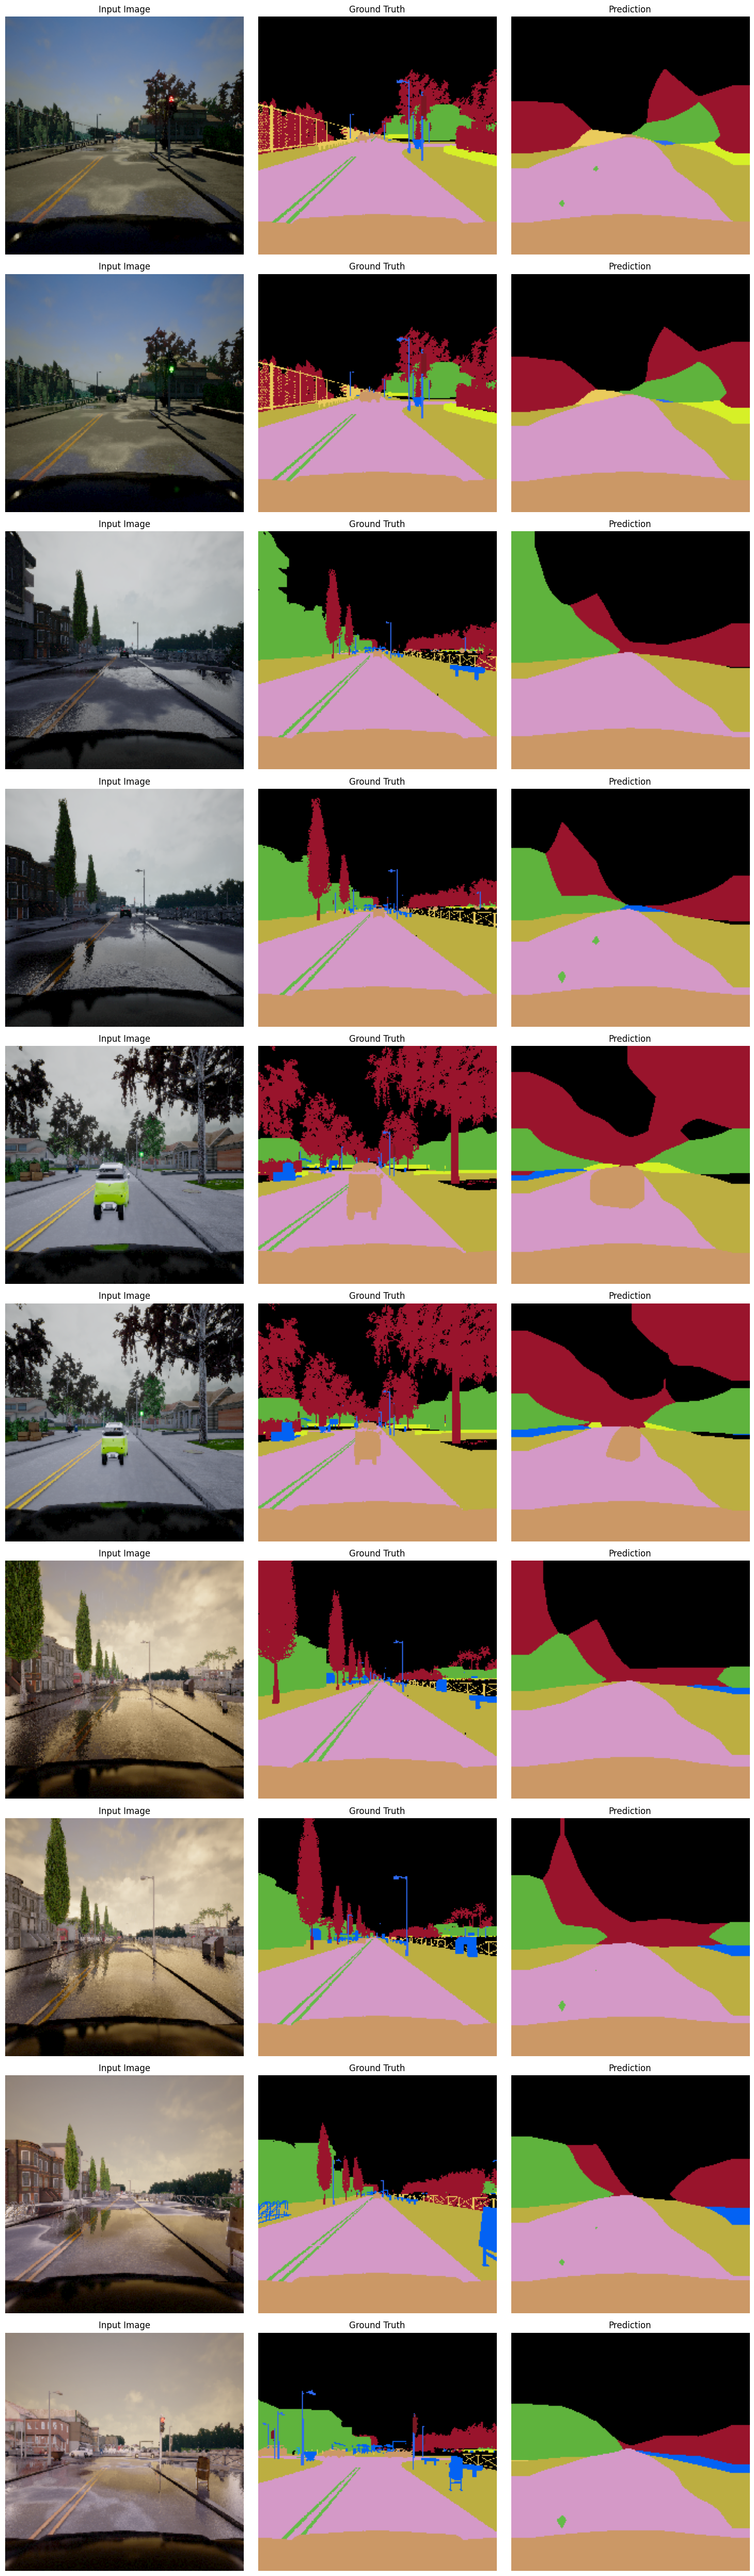

In [104]:
fcn32s_frozen, fcn32s_frozen_history = run_model_training(model_type='FCN32', freeze_backbone=False, epochs=1)

In [ ]:
print(fcn32s_frozen)

FCN32(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxP

In [ ]:
print(fcn32s_frozen_history)
"""
{'train_loss': [0.47018888092041017], 'val_loss': [0.34575093221664427], 'train_iou': [0.678943932056427], 'val_iou': [0.7441061735153198], 'class_ious': [array([0.83165115, 0.73510987, 0.18160753, 0.12903248, 0.        ,
       0.02725239, 0.00965769, 0.88347465, 0.7244929 , 0.60368484,
       0.9262284 , 0.32435006, 0.06454121], dtype=float32)], 'learning_rates': [1e-05]}
"""

{'train_loss': [0.47018888092041017], 'val_loss': [0.34575093221664427], 'train_iou': [0.678943932056427], 'val_iou': [0.7441061735153198], 'class_ious': [array([0.83165115, 0.73510987, 0.18160753, 0.12903248, 0.        ,
       0.02725239, 0.00965769, 0.88347465, 0.7244929 , 0.60368484,
       0.9262284 , 0.32435006, 0.06454121], dtype=float32)], 'learning_rates': [1e-05]}


Training FCN16_frozen


Epoch 1 Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.8224, mIoU: 0.6035 | Val Loss: 0.4577, mIoU: 0.7013 | LR: 0.000100 | Avg Batch Time: 0.843s
Per-class IoU:
  Unlabeled: 0.8072
  Building: 0.6430
  Fence: 0.1531
  Other: 0.1251
  Pedestrian: 0.0000
  Pole: 0.0120
  Roadline: 0.0142
  Road: 0.8483
  Sidewalk: 0.6425
  Vegetation: 0.5460
  Car: 0.8971
  Wall: 0.1252
  Traffic sign: 0.0002
Saved new best model with val_iou: 0.7013


Epoch 2 Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.4166, mIoU: 0.7167 | Val Loss: 0.3885, mIoU: 0.7394 | LR: 0.000100 | Avg Batch Time: 3.420s
Saved new best model with val_iou: 0.7394


Epoch 3 Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.3594, mIoU: 0.7426 | Val Loss: 0.3509, mIoU: 0.7375 | LR: 0.000100 | Avg Batch Time: 3.505s


Epoch 4 Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.3292, mIoU: 0.7568 | Val Loss: 0.3378, mIoU: 0.7465 | LR: 0.000100 | Avg Batch Time: 3.195s
Saved new best model with val_iou: 0.7465


Epoch 5 Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.3099, mIoU: 0.7659 | Val Loss: 0.3197, mIoU: 0.7654 | LR: 0.000100 | Avg Batch Time: 3.183s
Per-class IoU:
  Unlabeled: 0.8517
  Building: 0.7509
  Fence: 0.2374
  Other: 0.2451
  Pedestrian: 0.0000
  Pole: 0.0458
  Roadline: 0.0480
  Road: 0.8876
  Sidewalk: 0.7310
  Vegetation: 0.6314
  Car: 0.9360
  Wall: 0.3227
  Traffic sign: 0.1975
Saved new best model with val_iou: 0.7654
Training completed. Best validation mIoU: 0.7654 at epoch 5


Testing FCN16_frozen:   0%|          | 0/16 [00:00<?, ?it/s]


Test Results for FCN16_frozen:
Test Loss: 0.3281
Test Mean IoU: 0.7592

Per-class IoU:
  Unlabeled: 0.8489
  Building: 0.7431
  Fence: 0.2094
  Other: 0.2124
  Pedestrian: 0.0808
  Pole: 0.0546
  Roadline: 0.0532
  Road: 0.8841
  Sidewalk: 0.7322
  Vegetation: 0.6177
  Car: 0.9309
  Wall: 0.3334
  Traffic sign: 0.1577


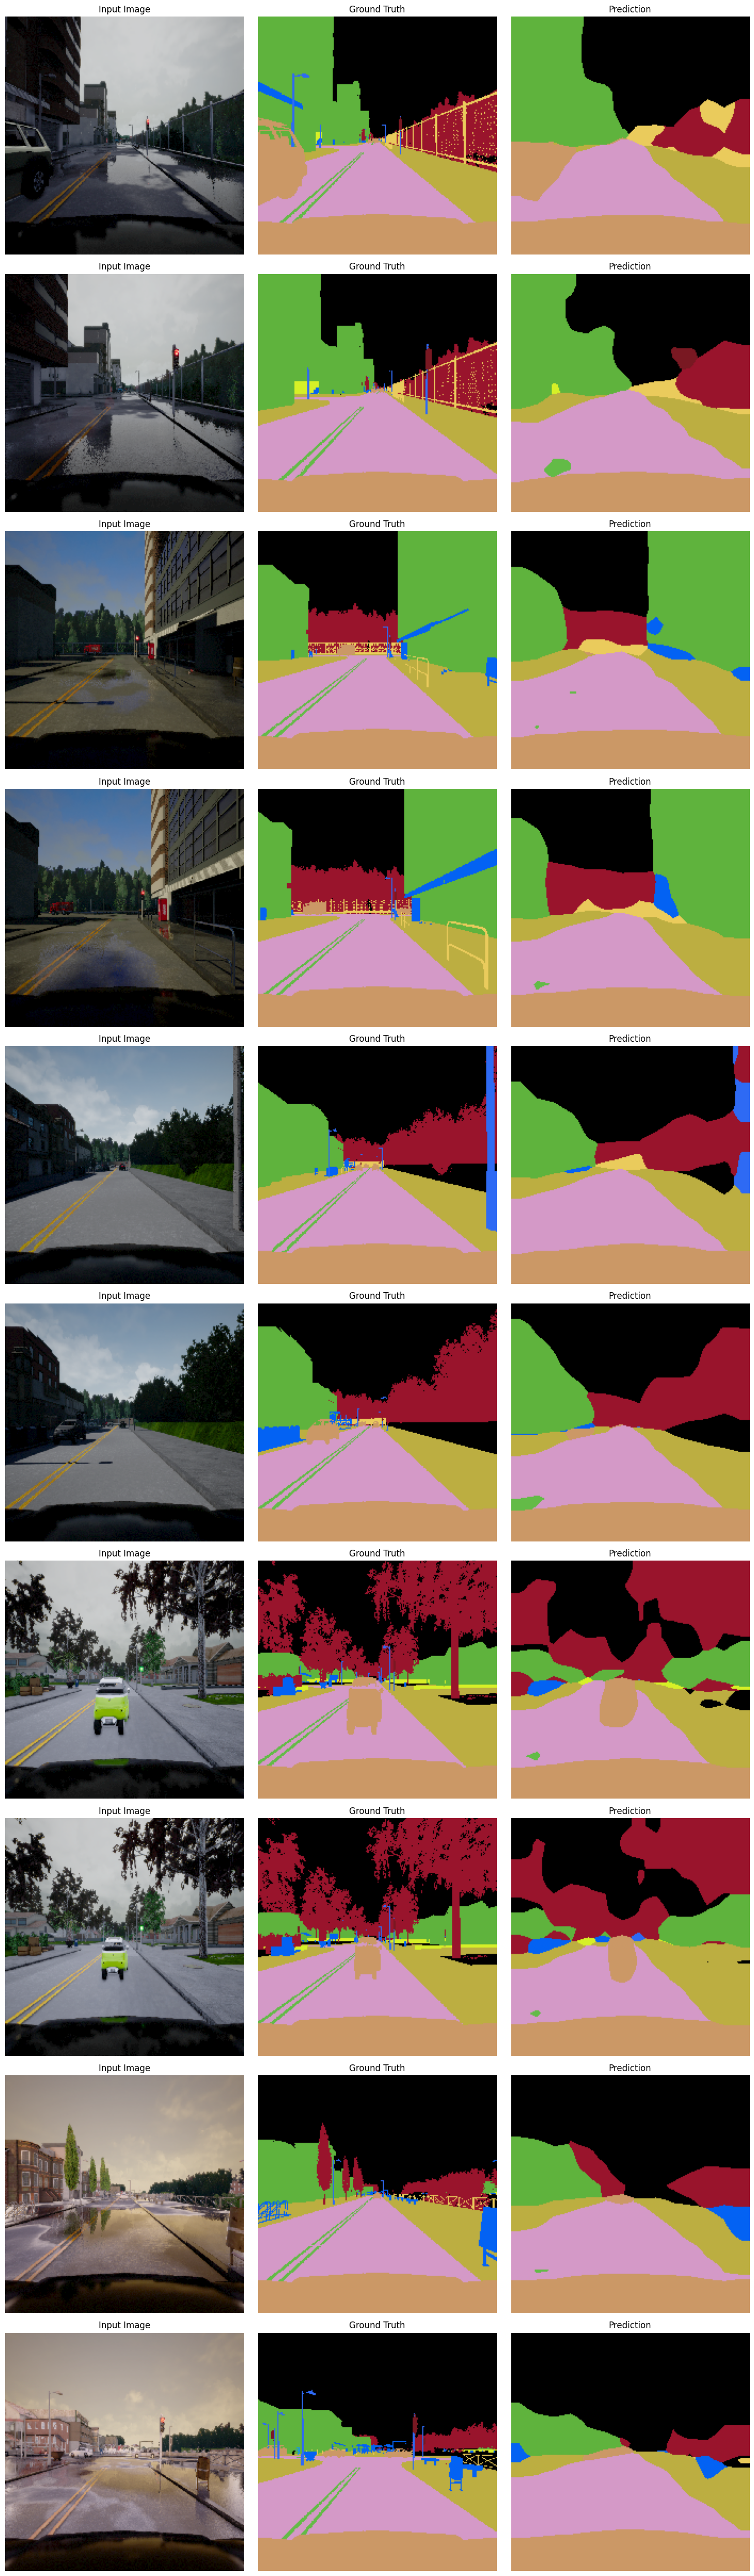

In [81]:
fcn16s_frozen, fcn16s_frozen_history = run_model_training(model_type='FCN16', freeze_backbone=True, epochs=5)

In [ ]:
fcn8s_frozen, fcn8s_frozen_history = run_model_training(model_type='FCN8', freeze_backbone=True, epochs=5)